In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore")

In [169]:
df=pd.read_csv('train.csv')
df['Time']=pd.to_datetime(df['Time'])#,format='%Y-%m-%d')
df=df.iloc[::-1]
df=df.iloc[5:2145,:]

In [170]:
Tuesday_df=pd.DataFrame()
for i in range(4,len(df),5):
    Tuesday_df=Tuesday_df.append(df.iloc[i,:])

In [171]:
for i in range(4,len(df),5):
    for j in df.columns.drop(['Positioning','lev Positioning','TFF1LATL INDEX','TFF1LLTL INDEX',
                              'TFF1LLTS INDEX','TFF1LATS INDEX','TFF1LAIL INDEX', 'TFF1LLFS INDEX',
                              'TFF1LAIS INDEX', 'TFF1LLFL INDEX']):
        Tuesday_df[j].iloc[i//5]=np.mean(df[j][(i-4):(i+1)])

In [172]:
Tuesday_df['Previous_pos']=pd.Series()
for i in range(1,len(Tuesday_df)):
    Tuesday_df['Previous_pos'].iloc[i]=Tuesday_df['Positioning'].iloc[i-1]

In [173]:
X=Tuesday_df.drop(['Time','Positioning','lev Positioning','Signal'], axis=1).iloc[1:,:]
y=Tuesday_df['Positioning'].iloc[1:]

In [174]:
from sklearn.ensemble import RandomForestRegressor
model_RF=RandomForestRegressor(n_estimators=20,random_state=0,criterion='mae',
                               min_samples_leaf = 2).fit(X,y)


mse=np.mean((y-model_RF.predict(X))**2)
ape=np.mean(np.abs((y-model_RF.predict(X))/y))

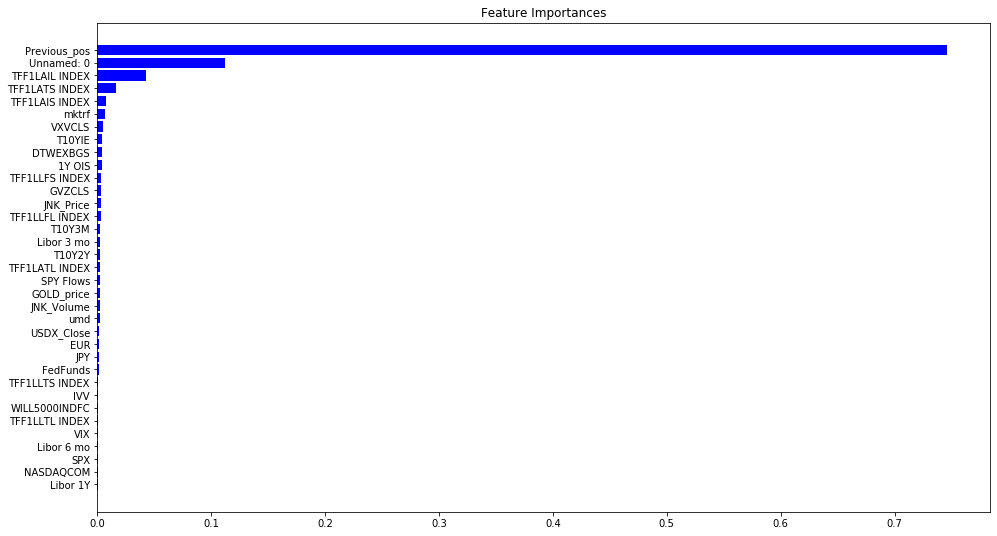

In [175]:
X_features = list(X.columns)
rf_importances = model_RF.feature_importances_
ind = np.argsort(rf_importances)

fig, ax = plt.subplots(figsize=(16,9))
ax.barh(range(len(ind)), rf_importances[ind], color='b', align='center')
ax.set(title = 'Feature Importances')
plt.yticks(range(len(ind)), [X_features[i] for i in ind])
plt.savefig('Feature Importances by RF',dpi=300)
plt.show()

In [176]:
ind=np.flip(ind)[:11]
selected=np.array(X_features)[ind]

In [177]:
X_train=Tuesday_df[selected].iloc[:350,:]
y_train=Tuesday_df['Positioning'][:350]
X_val=Tuesday_df[selected].iloc[350:,:]
y_val=Tuesday_df['Positioning'][350:]

In [178]:
Tuesday_df=Tuesday_df.drop(2139)

# Without Variable Selection

**RF**

In [229]:
from sklearn.ensemble import RandomForestRegressor
MSE=[]
APE=[]
start = time.time()
for i in range(350,len(Tuesday_df)):
    X_train=Tuesday_df.drop(['Signal','Time','Positioning'],axis=1).iloc[:i,:]
    y_train=Tuesday_df['Positioning'][:i]
    X_val=Tuesday_df.drop(['Signal','Time','Positioning'],axis=1).iloc[:i+1,:]
    y_val=Tuesday_df['Positioning'].iloc[i]
    model_RF=RandomForestRegressor(n_estimators=20,random_state=0,criterion='mae',
                                   min_samples_leaf = 2).fit(X_train,y_train)

    mse=(y_val-model_RF.predict(X_val)[-1])**2
    ape=np.abs((y_val-model_RF.predict(X_val)[-1])/y_val)
    MSE.append(mse)
    APE.append(ape)
end = time.time()
print('RF: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ',np.mean(APE))
print('Time elapsed: ',end-start)

RF: 
MSE is  139146879.36958608
Average Percentage Error is  0.07106715766955168
Time elapsed:  34.09981060028076


**VAR**

In [231]:
MSE=[]
APE=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    #assume stationarity at first
    y_val=Tuesday_df['Positioning'].iloc[i]
    mod = VAR(Tuesday_df.drop(['Signal','Time'],axis=1).iloc[:i,:]).fit(4)
    prediction=mod.forecast(np.array(Tuesday_df.drop(['Signal','Time'],axis=1).iloc[:i,:]),1)
    pos_index=[i for i, j in enumerate(Tuesday_df.drop(['Signal','Time'],axis=1).columns) if j == 'Positioning']
    y_predict=prediction[0][pos_index]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/y_val)
    MSE.append(mse)
    APE.append(ape)
end = time.time()
print('VAR: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ',np.mean(APE))
print('Time elapsed: ',end - start)

VAR: 
MSE is  351158315.80839247
Average Percentage Error is  0.12325159742969338
Time elapsed:  2.756408452987671


# After Variable Selection

# Benchmark RF given xvariable prediction week 

In [232]:
from sklearn.ensemble import RandomForestRegressor
MSE=[]
APE=[]

start = time.time()

for i in range(350,len(Tuesday_df)):
    X_train=Tuesday_df[selected].iloc[:i,:]
    y_train=Tuesday_df['Positioning'][:i]
    X_val=Tuesday_df[selected].iloc[:i+1]
    y_val=Tuesday_df['Positioning'].iloc[i]
    model_RF=RandomForestRegressor(n_estimators=20,random_state=0,criterion='mae',
                                   min_samples_leaf = 2).fit(X_train,y_train)


    mse=(y_val-model_RF.predict(X_val)[-1])**2
    ape=np.abs((y_val-model_RF.predict(X_val)[-1])/y_val)
    MSE.append(mse)
    APE.append(ape)
end = time.time()
print('RF: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ',np.mean(APE))
print('Time elapsed: ',end-start)

RF: 
MSE is  126892292.8017776
Average Percentage Error is  0.06605998847121877
Time elapsed:  10.438910007476807


# VAR NOT given xvariable prediction week

In [180]:
# deal with the extra lag for positioning
Varmax_df=Tuesday_df[np.append(selected,'Positioning')].iloc[1:,:]
pos=Tuesday_df['Positioning']
#dpos = (pos-pos.shift(1)).dropna()
#Varmax_df['dpos']=dpos


In [181]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

In [233]:
MSE=[]
APE=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    #assume stationarity at first
    y_val=Varmax_df['Positioning'].iloc[i]
    mod = VAR(Varmax_df.iloc[:i,:]).fit(4)
    prediction=mod.forecast(np.array(Varmax_df.iloc[:i,:]),1)
    pos_index=[i for i, j in enumerate(Varmax_df.columns) if j == 'Positioning']
    y_predict=prediction[0][pos_index]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/y_val)
    MSE.append(mse)
    APE.append(ape)
end = time.time()
print('VAR: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)

VAR: 
MSE is  149210405.93856087
Average Percentage Error is  0.07498488085972226
Time elapsed:  0.599123477935791


# Comment

1. Neither of these algos provides promising results. Any linear intuitive algorithms do not seems to provide good prediction. If we want to get more accurate predictions, we need to explore more "black box" type machine learning algorithms.
2. Variable Selection is very important for VAR, prefer less variables for optimal results （easily overfit)

# Pros

1. Very intuitive (I consider to be the best we can do in a linear sense with good variable selection)
2. fast fitting time, and minimal tuning (maybe useful for intraday trading)
3. Can deal with missing value for the day of prediction, in fact no need for any x variable on the prediction day, can only use past x variables

# Cons

1. Unlike more advanced models such as boosting, not much we can do to improve accuracy(limited to linear sense, cost for intuition)
2. Cannot capture trends yet (that are methods to deal with this not implemented yet)

# Steps to improve time series prediction

1. Better variable selection 
2. Explore different order for different variables (requires writing own library)
3. Check stationarity for every variable and use transforms if not stationary
4. **Use VARMAX which is strictly better than VAR, but the function is not well written, probably have to write the algo myself, huge time commitment**

# Questions

1. How intuitive does our methods have to be
2. What accuracy are you looking for. Even though the objective is as accurate as possible, but if given expectation, some of the methods can be ruled out with preliminary testing.